In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import pickle
from flask import Flask, request, jsonify
import threading


In [25]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/synthetic_pet_activity_data.csv")
print("Dataset Loaded Successfully")
df.head()


Dataset Loaded Successfully


,Timestamp,Pet_ID,Activity,Duration,Step_Count,Energy_Expended
0,2025-03-01 00:00:00,1,Running,279,84,7.16
1,2025-03-01 00:05:00,1,Lying,52,0,0.50
2,2025-03-01 00:10:00,1,Lying,389,0,0.42
3,2025-03-01 00:15:00,1,Sitting,149,0,0.71
4,2025-03-01 00:20:00,1,Drinking,363,0,0.63


In [26]:
print("Basic Info:")
print(df.info())
print("Summary Statistics:")
print(df.describe())
print("Missing Values:")
print(df.isnull().sum())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timestamp        1000 non-null   object 
 1   Pet_ID           1000 non-null   int64  
 2   Activity         1000 non-null   object 
 3   Duration         1000 non-null   int64  
 4   Step_Count       1000 non-null   int64  
 5   Energy_Expended  1000 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 47.0+ KB
None
Summary Statistics:
            Pet_ID     Duration   Step_Count  Energy_Expended
count  1000.000000  1000.000000  1000.000000       1000.00000
mean      5.500000   300.237000    33.443000          3.80397
std       2.873719   165.022226    53.252949          5.17550
min       1.000000    30.000000     0.000000          0.10000
25%       3.000000   156.000000     0.000000          0.60000
50%       5.500000   297.000000     0.000000          0

<ipython-input-27-f716f48d8d70>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Activity'], palette='coolwarm')


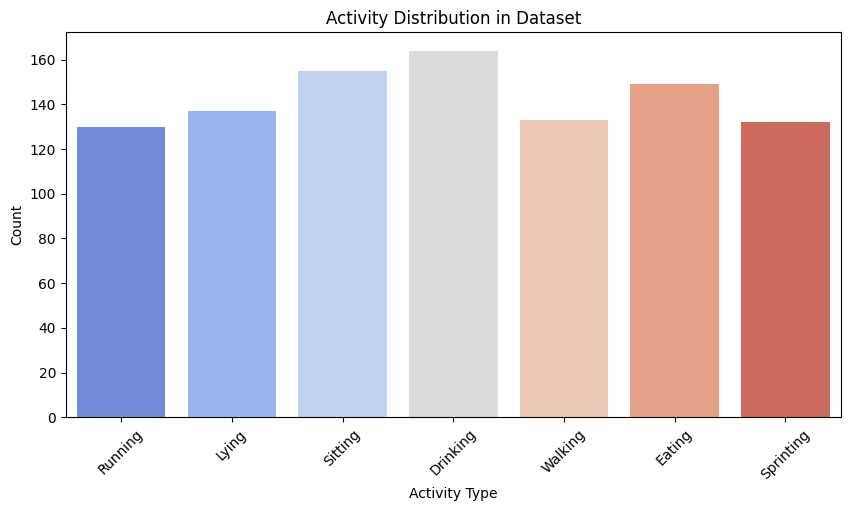

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['Activity'], palette='coolwarm')
plt.title("Activity Distribution in Dataset")
plt.xlabel("Activity Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [28]:
le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])
features = ['Duration', 'Step_Count', 'Energy_Expended']
X = df[features]
y = df['Activity']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Train-Test Split Completed")


Train-Test Split Completed


In [30]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Model Training Completed")


Model Training Completed


RF Accuracy: 0.70


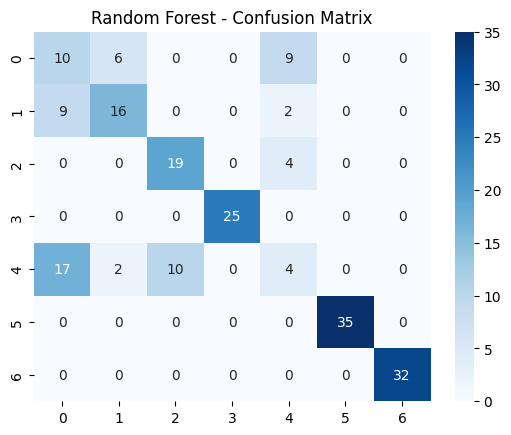

In [31]:
y_pred_rf =clf.predict(X_test)
print(f"RF Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()


In [32]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("CNN Model Created")


CNN Model Created


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, validation_data=(X_test_cnn, y_test))


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3307 - loss: 1.5618 - val_accuracy: 0.4550 - val_loss: 1.6364
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5764 - loss: 0.9998 - val_accuracy: 0.6400 - val_loss: 1.4050
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6344 - loss: 0.8005 - val_accuracy: 0.6900 - val_loss: 1.2163
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6508 - loss: 0.7491 - val_accuracy: 0.6050 - val_loss: 1.0942
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6634 - loss: 0.7060 - val_accuracy: 0.6100 - val_loss: 0.9717
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754 - loss: 0.7265 - val_accuracy: 0.6450 - val_loss: 0.8661
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6655 - loss: 0.6763 - val_accuracy: 0.6300 - val_loss: 0.8231
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.6368 - val_accuracy: 0.7100 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
CNN Accuracy: 0.74


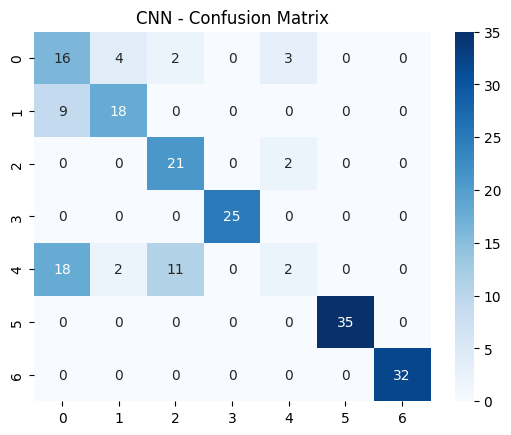

In [34]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
print(f"CNN Accuracy: {accuracy_score(y_test, y_pred_cnn):.2f}")
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Blues')
plt.title("CNN - Confusion Matrix")
plt.show()


In [35]:
df['Mean_Steps'] = df['Step_Count'].rolling(window=3, min_periods=1).mean()
df['Var_Steps'] = df['Step_Count'].rolling(window=3, min_periods=1).var()
df['Std_Steps'] = df['Step_Count'].rolling(window=3, min_periods=1).std()
df.fillna(0, inplace=True)


In [36]:
features_hybrid = ['Duration', 'Step_Count', 'Energy_Expended', 'Mean_Steps', 'Var_Steps', 'Std_Steps']
X_hybrid = df[features_hybrid]
y_hybrid = df['Activity']
X_hybrid_scaled = StandardScaler().fit_transform(X_hybrid)

X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X_hybrid_scaled, y_hybrid, test_size=0.2, random_state=42)
X_train_hybrid = X_train_hybrid.reshape(X_train_hybrid.shape[0], X_train_hybrid.shape[1], 1)
X_test_hybrid = X_test_hybrid.reshape(X_test_hybrid.shape[0], X_test_hybrid.shape[1], 1)


In [37]:
hybrid_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_hybrid.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

hybrid_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Hybrid CNN Model Created")


Hybrid CNN Model Created


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
hybrid_cnn.fit(X_train_hybrid, y_train_hybrid, epochs=20, batch_size=16, validation_data=(X_test_hybrid, y_test_hybrid))


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3858 - loss: 1.5314 - val_accuracy: 0.5100 - val_loss: 1.5388
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5816 - loss: 0.9442 - val_accuracy: 0.6050 - val_loss: 1.3204
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5925 - loss: 0.8966 - val_accuracy: 0.6700 - val_loss: 1.1512
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6300 - loss: 0.8025 - val_accuracy: 0.7400 - val_loss: 1.0098
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6507 - loss: 0.7933 - val_accuracy: 0.6300 - val_loss: 0.9182
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6254 - loss: 0.7662 - val_accuracy: 0.6350 - val_loss: 0.8040
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6547 - loss: 0.7292 - val_accuracy: 0.7150 - val_loss: 0.7148
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6678 - loss: 0.7093 - val_accuracy: 0.7000 - val_loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Hybrid CNN Accuracy: 0.72


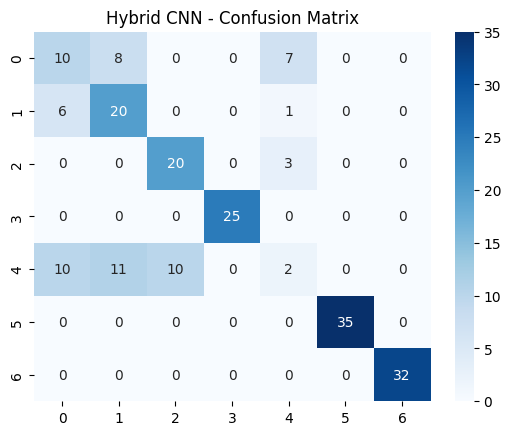

In [39]:
y_pred_hybrid = np.argmax(hybrid_cnn.predict(X_test_hybrid), axis=1)
print(f"Hybrid CNN Accuracy: {accuracy_score(y_test_hybrid, y_pred_hybrid):.2f}")
sns.heatmap(confusion_matrix(y_test_hybrid, y_pred_hybrid), annot=True, fmt='d', cmap='Blues')
plt.title("Hybrid CNN - Confusion Matrix")
plt.show()


<ipython-input-40-c383d9bce8f2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="coolwarm")


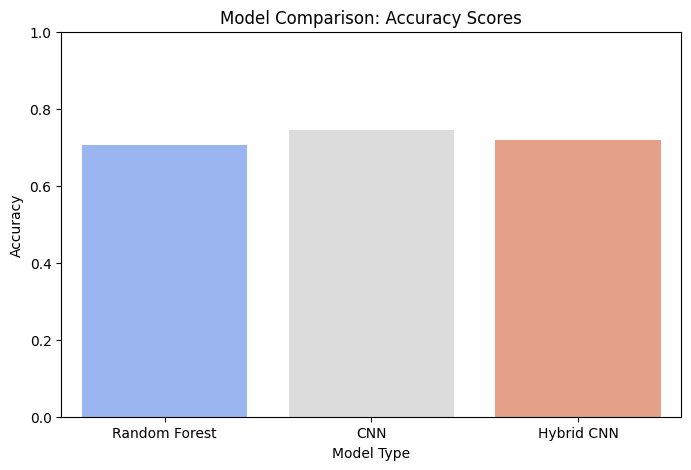

In [40]:
models = ["Random Forest", "CNN", "Hybrid CNN"]
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_cnn),
    accuracy_score(y_test_hybrid, y_pred_hybrid)
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette="coolwarm")
plt.title("Model Comparison: Accuracy Scores")
plt.xlabel("Model Type")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


In [42]:
joblib.dump(clf, "random_forest_model.pkl")

['random_forest_model.pkl']

In [43]:
cnn_model.save("cnn_model.h5")

In [44]:
hybrid_cnn.save("hybrid_cnn_model.h5")

In [45]:
def deploy_model(model_path, model_type):
    print(f"Deploying {model_type} Model...")
    if model_type == "RF":
        model = joblib.load(model_path)
    else:
        model = tf.keras.models.load_model(model_path)
    print(f"{model_type} Model Successfully Deployed")

In [46]:
deploy_model("random_forest_model.pkl", "RF")
deploy_model("cnn_model.h5", "CNN")
deploy_model("hybrid_cnn_model.h5", "Hybrid CNN")

Deploying RF Model...
RF Model Successfully Deployed
Deploying CNN Model...
CNN Model Successfully Deployed
Deploying Hybrid CNN Model...
Hybrid CNN Model Successfully Deployed


In [47]:
def real_time_processing():
    print("Starting Real-Time Processing...")
    for _ in range(5):  # Simulating 5 real-time data inputs
        new_data = np.array([[np.random.randint(30, 600), np.random.randint(0, 200), np.random.uniform(0.1, 20)]])
        new_data_scaled = scaler.transform(new_data)
        predicted_activity = le.inverse_transform(clf.predict(new_data_scaled))
        print(f"Real-Time Predicted Activity: {predicted_activity[0]}")

t = threading.Thread(target=real_time_processing)
t.start()


Starting Real-Time Processing...


In [48]:
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    new_data = np.array([[data['Duration'], data['Step_Count'], data['Energy_Expended']]])
    new_data_scaled = scaler.transform(new_data)
    predicted_activity = le.inverse_transform(clf.predict(new_data_scaled))
    return jsonify({'Predicted Activity': predicted_activity[0]})

if __name__ == '__main__':
    app.run(debug=True)
    print("API Running - Send POST Requests to /predict")


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


API Running - Send POST Requests to /predict


In [50]:
def update_model(new_model_path):
    global clf
    clf = joblib.load(new_model_path)
    print("Model Updated Successfully!")
